In [1]:
import numpy as np
import pandas as pd
import warnings
from keras.models import load_model
from gensim.models.keyedvectors import KeyedVectors
from keras.layers import Embedding
from keras.optimizers import Adam
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Input
from keras.layers import Activation
from sklearn.model_selection import StratifiedKFold, KFold


import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

Using TensorFlow backend.
c:\users\acer\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
train_data=pd.read_csv('data_bersih_helmi.csv', usecols=["text","sentiment"], encoding='latin-1')
print(train_data.head(5))
print("Has null values: ", train_data.isnull().values.any())

                                                text sentiment
0         sangat memuaskan untuk perjalanan ke jogja  positive
1                    kamar yang nyaman dan unik suka  positive
2  hotel direkomendasikan banget deh pokoknya pel...  positive
3  sangat menyenangkan lokasinya yang dekat dari ...  positive
4                    pelayanan yang baik mudah akses  positive
Has null values:  False


In [3]:
sentiments = train_data.sentiment.unique()
dict={}
for i,sentiment in enumerate(sentiments):
    dict[sentiment]=i
labels = train_data.sentiment.apply(lambda x:dict[x])

In [4]:
NUM_WORDS = 7000
MAX_SEQUENCE_LENGTH = 50

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [6]:
texts=train_data.text
tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(train_data.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5635 unique tokens.


In [7]:
#panjang input masukan
X = pad_sequences(sequences_train, maxlen= MAX_SEQUENCE_LENGTH)
y = to_categorical(np.asarray(labels))
print('Shape of X_train tensor:', X.shape)
print('Shape of y_train tensor:', y.shape)

Shape of X_train tensor: (5000, 50)
Shape of y_train tensor: (5000, 2)


In [8]:
#SPlit data training dan testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print ('Data Training:', X_train.shape)
print ('Data Testing:', X_test.shape)
# print ('Data Validation:', X_val.shape)

Data Training: (4000, 50)
Data Testing: (1000, 50)


In [9]:
from gensim.models.doc2vec import Doc2Vec
word_vectors= Doc2Vec.load("F:/Codingku/Doc2Vec/model_doc2vec.bin")

KeyboardInterrupt: 

In [9]:
%%time
word_vectors = KeyedVectors.load_word2vec_format \
    ('F:/Codingku/Glove/Glove_300/glove-300.word2vec', binary=False, encoding='latin-1')
print('Found %s word vectors of word2vec' % len(word_vectors.vocab))

Found 1492755 word vectors of word2vec
Wall time: 16min 3s


In [10]:
EMBEDDING_DIM=300
vocabulary_size = min(len(word_index)+1,NUM_WORDS)
#print (len(vocabulary_size))
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError as e:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
#         pass

print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 1


In [11]:
embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length = MAX_SEQUENCE_LENGTH, trainable=False)

In [27]:
%%time
from keras.optimizers import Nadam
kfold = KFold(n_splits= 10, random_state=None, shuffle=True)
cvscores = []
for train, val in kfold.split(X_train,y_train):
    adam = Adam(lr=0.001)
    
    #buat model
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding= embedding_layer(sequence_input)
    model_lstm = LSTM(100)(embedding)
    dropout = Dropout(0.8)(model_lstm)
    preds = (Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))(dropout)
    model = Model(sequence_input, preds)
    model.compile(loss = 'binary_crossentropy', optimizer= adam, metrics = ['accuracy'])
    print(model.summary())

#     model = Sequential()
#     model.add(Embedding(input_dim=embedding_matrix.shape[0], input_length = MAX_SEQUENCE_LENGTH, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix]))
#     model.add(LSTM(100, dropout=0.2))
#     model.add(Dense(2,activation='sigmoid'))
#     model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    

    history = model.fit(X_train[train], y_train[train], batch_size=128, epochs=10, validation_data=(X_train[val], y_train[val]), verbose=0)

    score= model.evaluate(X_train[val], y_train[val])
    print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    cvscores.append(score[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           1690800   
_________________________________________________________________
lstm_21 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 202       
Total params: 1,851,402
Trainable params: 160,602
Non-trainable params: 1,690,800
_________________________________________________________________
None
400/400 [==============================] - 0s 644us/step
acc: 96.75%
____________________________________________________

400/400 [==============================] - 0s 691us/step
acc: 96.38%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           1690800   
_________________________________________________________________
lstm_29 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 202       
Total params: 1,851,402
Trainable params: 160,602
Non-trainable params: 1,690,800
_________________________________________________________________
None
400/400 [==============================] - 0s 705us/

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


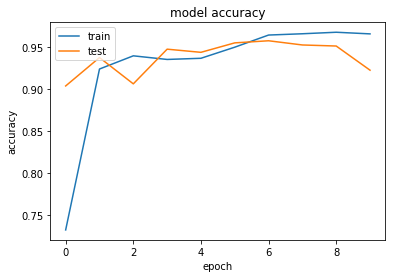

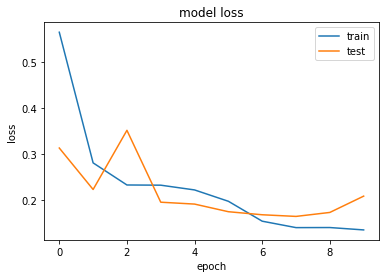

In [28]:
# Plot Model Loss and Model accuracy
print(history.history.keys()) 
# summarize history for accuracy 
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) # RAISE ERROR 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show() 
# summarize history for loss 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) #RAISE ERROR 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper right') 
plt.show() 

In [29]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

array([[False,  True],
       [False,  True],
       [False,  True],
       ...,
       [False,  True],
       [ True, False],
       [ True, False]])

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm

array([[485,  21],
       [ 36, 458]], dtype=int64)

In [18]:
model.save('model-Glove300-epoh10.h5')
print("Model has created!")

Model has created!


In [19]:
text = ("kamar luas pemandangan bagus parkir luas nyaman sekali di hotel ini")
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen= MAX_SEQUENCE_LENGTH)

model = load_model('model-4.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[4])

sentiment = ['positive', 'negative']

print("Text: ",text)
print("Sentiment: ",sentiment[polarity])

Text:  kamar luas pemandangan bagus parkir luas nyaman sekali di hotel ini
Sentiment:  negative


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Akurasinya: 0.942
Confusion matrix, without normalization
[[485  21]
 [ 36 458]]


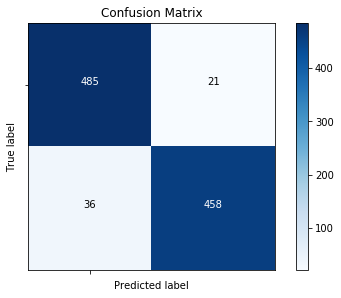

In [32]:
akur = accuracy_score(y_test, y_pred)
print("Akurasinya:", akur)
cm_plot_labels = ['']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [26]:
from sklearn.metrics import classification_report
target_names = ['Positive','Negative']
print(classification_report(y_test, y_pred, target_names = target_names ))
akurasi = accuracy_score(y_test, y_pred)
print("Akurasi:", akurasi)

              precision    recall  f1-score   support

    Positive       0.97      0.93      0.95       506
    Negative       0.93      0.97      0.95       494

   micro avg       0.95      0.95      0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000
 samples avg       0.95      0.95      0.95      1000

Akurasi: 0.952
